## Investigating the Impact of AI Technologies on Fraudulent Amazon Reviews Using Similarity Analysis.

In [1]:
import sys
print(sys.version)
print(spark.version)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
3.5.1


### EDA

In [2]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum
from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
gcs_folder = 'gs://msca-bdp-data-open/final_project_reviews'

In [4]:
cmd = 'gsutil du -s -h ' + gcs_folder

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (f'Total directory size: {line}')
    
retval = p.wait() # Wait for the child process to terminate.

Total directory size: 75.75 GiB    gs://msca-bdp-data-open/final_project_reviews



In [5]:
%%time   
    
df_reviews = spark.read.parquet(os.path.join(gcs_folder, 'reviews_parquet'))
print(f'Records read from dataframe *reviews*: {df_reviews.count():,.0f}')

Records read from dataframe *reviews*: 64,679,785
CPU times: user 19.6 ms, sys: 9.04 ms, total: 28.7 ms
Wall time: 17 s


In [6]:
display(df_reviews.printSchema())

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



None

In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
df_reviews.limit(2)

asin,helpful_vote,parent_asin,rating,text,timestamp,title,user_id,verified_purchase
B00HSAOFD8,0,B00HSAOFD8,4.0,Brushes arrived q...,1453819207000,Four Stars,AGWL43EG6H3AO3CN2...,true
B07MGKRMBG,0,B07SPY1GJG,5.0,I have tried just...,1600341347791,Finally a natural...,AGUUIUEN3Y4X54WXM...,true


In [9]:
num_rows = df_reviews.count()
num_cols = len(df_reviews.columns)

print(f"Shape: ({num_rows}, {num_cols})")

Shape: (64679785, 9)


### Question-1: Discard irrelevant or obviously erroneous data

**Most of the variable names should be self-explanatory, however data is deeply nested and will require detailed review in order to select the most appropriate data elements**

***Checking column wise null values for df_reviews***

In [10]:
from pyspark.sql.functions import col, lower, trim, count, when

null_like_values = ["null", "none", "nan", "n/a", ""]

for column in df_reviews.columns:
    print(f"\nChecking column: {column}")
    
    df_reviews.select(
        count(when(col(column).isNull(), column)).alias("True Nulls"),
        *[
            count(when(lower(trim(col(column))) == val, column)).alias(f"'{val}' strings")
            for val in null_like_values
        ]
    ).show()


Checking column: asin


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: helpful_vote


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: parent_asin


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: rating


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: text


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             9|          7895|            2|        12909|     88026|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: timestamp


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: title


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|            12|          8460|           23|        13665|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: user_id


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: verified_purchase


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+



In [11]:
df_clean_reviews = df_reviews.filter(
    col("text").isNotNull() &
    col("title").isNotNull() &
    (~lower(trim(col("text"))).isin(null_like_values)) &
    (~lower(trim(col("title"))).isin(null_like_values))
)

In [12]:
df_clean_reviews.count()

64556967

***By cleaning out all null like values, we have reduced the dataset df_reviews from 64679785 to 64556967***

In [13]:
from pyspark.sql.functions import countDistinct
for col in df_clean_reviews.columns:
    distinct_count=df_clean_reviews.select(countDistinct(col)).collect()[0][0]
    print(f" {col}: {distinct_count} unique values")

 asin: 5313448 unique values


 helpful_vote: 1503 unique values


 parent_asin: 4316730 unique values


 rating: 5 unique values


 text: 55276279 unique values


 timestamp: 62581133 unique values


 title: 25160013 unique values


 user_id: 22749760 unique values


 verified_purchase: 2 unique values


In [14]:
from pyspark.sql.functions import from_unixtime, col

df_clean_reviews = df_clean_reviews.withColumn(
    "review_datetime",
    from_unixtime(col("timestamp") / 1000)
)

In [15]:
df_clean_reviews.limit(10).show()

+----------+------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+-------------------+
|      asin|helpful_vote|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|    review_datetime|
+----------+------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+-------------------+
|B00HSAOFD8|           0| B00HSAOFD8|   4.0|Brushes arrived q...|1453819207000|          Four Stars|AGWL43EG6H3AO3CN2...|             true|2016-01-26 14:40:07|
|B07MGKRMBG|           0| B07SPY1GJG|   5.0|I have tried just...|1600341347791|Finally a natural...|AGUUIUEN3Y4X54WXM...|             true|2020-09-17 11:15:47|
|B01FOJ7EVO|           0| B09J7FM96G|   4.0|Love Mediheal but...|1607280179211|    Too small for me|AGOX7WJIY67A3OOKT...|             true|2020-12-06 18:42:59|
|B01B8ABHK2|           0| B016O0QZEO|   

### Question-2: Complete thorough EDA to identify which variables you can use to complete your analysis

**Any poorly populated or duplicate variables should be discarded**

In [16]:
df_clean_reviews = df_clean_reviews.drop("timestamp")

In [17]:
%%time

df_meta = spark.read.parquet(os.path.join(gcs_folder, 'meta_parquet'))
print(f'Records read from dataframe *meta*: {df_meta.count():,.0f}')

Records read from dataframe *meta*: 4,320,533
CPU times: user 2.05 ms, sys: 3.63 ms, total: 5.68 ms
Wall time: 1.37 s


In [18]:
display(df_meta.printSchema())

root
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- store: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- title: string (nullable = true)



None

In [19]:
df_meta.limit(2)

author,average_rating,bought_together,categories,description,main_category,parent_asin,price,rating_number,store,subtitle,title
NULL,5.0,NULL,[Beauty & Persona...,[],All Beauty,B0771WJBHK,NULL,5,Bare Alchemy,NULL,Soothe Serum for ...
NULL,4.0,NULL,[Beauty & Persona...,[],NULL,B09NKNNS57,NULL,17,DISCOVER DEVICE,NULL,DISCOVER Tattoo B...


In [20]:
num_rows_meta = df_meta.count()
num_cols_meta = len(df_meta.columns)

print(f"Shape: ({num_rows_meta}, {num_cols_meta})")

Shape: (4320533, 12)


In [21]:
from pyspark.sql.functions import col, lower, trim, count, when
from pyspark.sql.types import StringType

null_like_values = ["null", "none", "nan", "n/a", ""]

# Only string columns
string_cols = [f.name for f in df_meta.schema.fields if isinstance(f.dataType, StringType)]

# Check each column safely
for column in string_cols:
    print(f"\nChecking column: {column}")
    
    df_meta.select(
        count(when(col(column).isNull(), column)).alias("True Nulls"),
        *[
            count(when(lower(trim(col(column))) == val, column)).alias(f"'{val}' strings")
            for val in null_like_values
        ]
    ).show()


Checking column: bought_together


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|   4320533|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: main_category


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|    249444|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: parent_asin


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: price


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|   2555695|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: store


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|     87815|            22|           199|            0|            5|         5|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: subtitle


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|   4318198|             0|             0|            0|            0|         0|
+----------+--------------+--------------+-------------+-------------+----------+


Checking column: title


+----------+--------------+--------------+-------------+-------------+----------+
|True Nulls|'null' strings|'none' strings|'nan' strings|'n/a' strings|'' strings|
+----------+--------------+--------------+-------------+-------------+----------+
|         0|             3|             0|            5|            1|       218|
+----------+--------------+--------------+-------------+-------------+----------+



In [22]:
from pyspark.sql.functions import col, count, size, when

df_meta.select(
    count(when(col("author").isNull(), "author")).alias("author IS NULL")
).show()

df_meta.select(
    count(when(col("author.name").isNull(), "name")).alias("name IS NULL"),
    count(when(col("author.avatar").isNull(), "avatar")).alias("avatar IS NULL"),
    count(when(col("author.about").isNull(), "about")).alias("about IS NULL"),
    count(when(size(col("author.about")) == 0, "about")).alias("about is EMPTY array")
).show()

+--------------+
|author IS NULL|
+--------------+
|       4320377|
+--------------+



+------------+--------------+-------------+--------------------+
|name IS NULL|avatar IS NULL|about IS NULL|about is EMPTY array|
+------------+--------------+-------------+--------------------+
|     4320377|       4320377|      4320377|                   0|
+------------+--------------+-------------+--------------------+



***Clearly many authors struct, bought_together, subtitle are null, so we need to drop these variables.***

In [23]:
from pyspark.sql.functions import col, count, size, when

df_meta.select(
    count(when(col("categories").isNull(), "categories")).alias("categories IS NULL"),
    count(when(size(col("categories")) == 0, "categories")).alias("categories is EMPTY array")
).show()

df_meta.select(
    count(when(col("description").isNull(), "description")).alias("description IS NULL"),
    count(when(size(col("description")) == 0, "description")).alias("description is EMPTY array")
).show()

+------------------+-------------------------+
|categories IS NULL|categories is EMPTY array|
+------------------+-------------------------+
|                 0|                   355136|
+------------------+-------------------------+



+-------------------+--------------------------+
|description IS NULL|description is EMPTY array|
+-------------------+--------------------------+
|                  0|                   1855488|
+-------------------+--------------------------+



In [24]:
df_clean_meta = df_meta.drop("author","bought_together","subtitle","description")

In [25]:
df_clean_meta = df_clean_meta.withColumnRenamed("title", "product_title")

In [26]:
df_clean_meta.show()

+--------------+--------------------+--------------------+-----------+-----+-------------+--------------------+--------------------+
|average_rating|          categories|       main_category|parent_asin|price|rating_number|               store|       product_title|
+--------------+--------------------+--------------------+-----------+-----+-------------+--------------------+--------------------+
|           5.0|[Beauty & Persona...|          All Beauty| B0771WJBHK| NULL|            5|        Bare Alchemy|Soothe Serum for ...|
|           4.0|[Beauty & Persona...|                NULL| B09NKNNS57| NULL|           17|     DISCOVER DEVICE|DISCOVER Tattoo B...|
|           4.6|[Beauty & Persona...|          All Beauty| B0C6FF5HWL| 8.99|          137|             auroray|auroray 2200 Pcs ...|
|           1.0|[Beauty & Persona...|                NULL| B09NKSHV3Z|15.69|            2|                KKNC|KKNC Chemistry In...|
|           5.0|[Beauty & Persona...|          All Beauty| B000C213AC

In [27]:
df_joined = df_clean_reviews.join(df_clean_meta, on="parent_asin", how="left")

In [28]:
df_joined.limit(10).toPandas()

,parent_asin,asin,helpful_vote,rating,text,title,user_id,verified_purchase,review_datetime,average_rating,categories,main_category,price,rating_number,store,product_title
0,1733646868,1733646868,2,5.0,I taught a class on Sketchnoting this summer and bought this book for every student. Sylvia's book was the perfect curriculum and it was so easy for everyone to follow her steps on how to create the different icons. I would highly recommend this to everyone who wants to learn how to Sketchnote!,Awesome book,AHCELFIFPYKEXSOO2PGOIPXHBHMQ,False,2019-08-16 14:48:01,4.5,"[Automotive, RV Parts & Accessories, Exterior]",Books,14.61,277,Sylvia Duckworth (Author),How to Sketchnote: A Step-by-Step Manual for Teachers and Students
1,B0000532A2,B0000532A2,0,5.0,Love these tweezers is my second wind I miss placed the first one and I thought I was going to have a fit but I got mine from here being Amazon and I’m a happy camper,Fantastic,AG32DCL4TAWPT26CAWTOUODS6S2Q,False,2019-12-22 04:49:24,4.6,"[Beauty & Personal Care, Shave & Hair Removal, Women's, Tweezers]",Health & Personal Care,5.6,38331,REVLON,"Revlon Expert Eyebrow Hair Removal Tweezer, Tweezers for Men, Women & Kids, Stainless Steel"
2,B002QASVFS,B002QASVFS,0,4.0,The colors dont have that much pigment in them so you really have to layer it on to see the shimmer. I usually layer it on top of the regular 88 palette. The blending is easy and the colors last pretty long. A minor flaw is that the applicators arent that great. I wouldnt recommend anyone of a dark complexion to get it only because of the lack of pigment(you wouldnt be able to see the color unless you layer it on a similar color like I do) but overall its a good product.,It's ok,AEAMPNO3RV4XGR4MMYV63FCLGFFA,True,2010-04-19 15:18:45,4.2,"[Beauty & Personal Care, Makeup, Makeup Palettes]",All Beauty,None,1775,Coastal Scents,"Coastal Scents 88 Palette, Ultra Shimmer"
3,B00K1IUYVQ,B00K1IUYVQ,0,5.0,Good product and Great Seller.,Five Stars,AEI2CM5PSXHN2IH5VJ4SAHAEX37A,True,2016-01-05 03:50:45,4.2,"[Beauty & Personal Care, Shave & Hair Removal, Women's, Tweezers]",Tools & Home Improvement,None,220,Creative Hobbies,Creative Hobbies 4 Piece Tweezers - Craft Jewelry Beauty Nail Art Hobby Picking Tool
4,B00TBSY0PS,B00TBSY0PS,0,5.0,This product works great! Doubles lash size,Great mascara,AFUO6WI42GA5ZQTPJ2E2GVFYNGWQ,True,2018-09-14 04:00:41,4.0,"[Beauty & Personal Care, Makeup, Eyes, Mascara]",All Beauty,25.0,5316,Simply Naked Beauty,3D Lash Fiber Mascara (2 Tubes) - Lengthening Tubing Mascara for Bold Volume - Gel & Dry Fiber Formula - Non-Toxic & Hypoallergenic by Simply Naked Beauty
5,B00WT8O1M4,B00WT8O1M4,0,5.0,Great case awsome buy,Five Stars,AG5L446UXD4NWUKLXQHTNLTUUHEQ,True,2016-04-06 17:17:14,4.3,"[Cell Phones & Accessories, Cases, Holsters & Sleeves, Holsters]",Cell Phones & Accessories,None,331,Evocel,"Evocel Galaxy S6 Edge Case, [New Generation] Dual Layer Rugged Holster Case with Kickstand & Belt Clip for Samsung Galaxy S6 Edge SM-G925 (Does NOT fit S6 Edge Plus - S6 Edge only), Blue"
6,B01J1W0F2A,B002ANOZZG,0,3.0,"the scent is phenomenal, however the lather is lackluster. I use some pacific shaving co. creme and its far superior to this, The small tub it comes in doesn't exactly make for applying the soap to the brush from the container without making a mess so I transfer it to my bowl, cover my brush tips and then place the bar back in the tub for storage. any other way just leaves the tub messy.",not what I expected,AHRTJLZKOHTEF5WWQTKLIPFQDHLQ,True,2013-10-29 03:18:29,4.4,"[Beauty & Personal Care, Shave & Hair Removal, Men's, Shaving Creams, Lotions & Gels, Shaving Soaps]",All Beauty,23.5,1015,Edwin Jagger,"Edwin Jagger 99.9% Natural Traditional Shaving Soap In Travel Tub - Aloe Vera, 2.3-Ounce"
7,B01M65JBV7,B003BZIN1O,0,5.0,"Perfect Fit, great quality.<br />2003 Mini Cooper S, 6 spd",Five Stars,AHHDGGORFEWWFR2YU65VEW64Y23Q,False,2014-10-18 01:05:58,4.4,"[Automotive, Replacement Parts, Windshield Wipers & Washers, Wiper

In [29]:
df_joined.select(count(when(col("asin").isNull(),1)).alias("asin is NULL")).show()

+------------+
|asin is NULL|
+------------+
|           0|
+------------+



In [30]:
df_joined.printSchema()

root
 |-- parent_asin: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_datetime: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- store: string (nullable = true)
 |-- product_title: string (nullable = true)



In [31]:
df_final = df_joined.withColumnRenamed("title", "review_title") 

df_final = df_final.select(
    "asin", "parent_asin", "review_title", "text", "rating", "helpful_vote",
    "verified_purchase", "user_id", "review_datetime",
    "price", "main_category", "categories", "store"
)

df_final.limit(5).toPandas()

,asin,parent_asin,review_title,text,rating,helpful_vote,verified_purchase,user_id,review_datetime,price,main_category,categories,store
0,B00K1IUYVQ,B00K1IUYVQ,Five Stars,Good product and Great Seller.,5.0,0,True,AEI2CM5PSXHN2IH5VJ4SAHAEX37A,2016-01-05 03:50:45,None,Tools & Home Improvement,"[Beauty & Personal Care, Shave & Hair Removal, Women's, Tweezers]",Creative Hobbies
1,B00TBSY0PS,B00TBSY0PS,Great mascara,This product works great! Doubles lash size,5.0,0,True,AFUO6WI42GA5ZQTPJ2E2GVFYNGWQ,2018-09-14 04:00:41,25.0,All Beauty,"[Beauty & Personal Care, Makeup, Eyes, Mascara]",Simply Naked Beauty
2,B00WT8O1M4,B00WT8O1M4,Five Stars,Great case awsome buy,5.0,0,True,AG5L446UXD4NWUKLXQHTNLTUUHEQ,2016-04-06 17:17:14,None,Cell Phones & Accessories,"[Cell Phones & Accessories, Cases, Holsters & Sleeves, Holsters]",Evocel
3,B01N1RO1U4,B01N1RO1U4,Trash Bag,This bag is great and fits perfect in my car.,5.0,0,True,AELMWB3S3LHGSTN2OGIWXWCZPNQQ,2022-04-15 00:30:09,14.95,Automotive,"[Automotive, Interior Accessories, Garbage Cans]",OxGord
4,B089VPLW23,B089VPLW23,Really tough,Excellent way to protect your phone.,5.0,0,True,AE42OKE4GS7JVWO7VPRYVSWJBARQ,2021-06-13 02:22:15,10.5,Cell Phones & Accessories,"[Cell Phones & Accessories, Cases, Holsters & Sleeves, Basic Cases]",OtterBox


In [32]:
df_final.select([
    count(when(col(c).isNull(), 1)).alias(f"{c}_nulls") for c in df_final.columns
]).show(truncate=False)

+----------+-----------------+------------------+----------+------------+------------------+-----------------------+-------------+---------------------+-----------+-------------------+----------------+-----------+
|asin_nulls|parent_asin_nulls|review_title_nulls|text_nulls|rating_nulls|helpful_vote_nulls|verified_purchase_nulls|user_id_nulls|review_datetime_nulls|price_nulls|main_category_nulls|categories_nulls|store_nulls|
+----------+-----------------+------------------+----------+------------+------------------+-----------------------+-------------+---------------------+-----------+-------------------+----------------+-----------+
|0         |0                |0                 |0         |0           |0                 |0                      |0            |0                    |22027749   |1198222            |0               |1527533    |
+----------+-----------------+------------------+----------+------------+------------------+-----------------------+-------------+--------------

***We cannot drop the fields price,main category and store as there is a chance we might need them later, so we will fill them with values***

In [33]:
df_final = df_final.fillna({
    "price": -1, 
    "main_category": "Unknown",
    "store": "Unknown"
})

In [34]:
df_final.select([
    count(when(col(c).isNull(), 1)).alias(f"{c}_nulls") for c in df_final.columns
]).toPandas()

,asin_nulls,parent_asin_nulls,review_title_nulls,text_nulls,rating_nulls,helpful_vote_nulls,verified_purchase_nulls,user_id_nulls,review_datetime_nulls,price_nulls,main_category_nulls,categories_nulls,store_nulls
0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Question-3: What is the timeline of the data?  

In [35]:
from pyspark.sql.functions import to_date, count

df_timeline = df_final.withColumn("review_date", to_date("review_datetime")) \
                      .groupBy("review_date") \
                      .agg(count("*").alias("review_count")) \
                      .orderBy("review_date")

In [36]:
df_timeline_pd = df_timeline.toPandas()

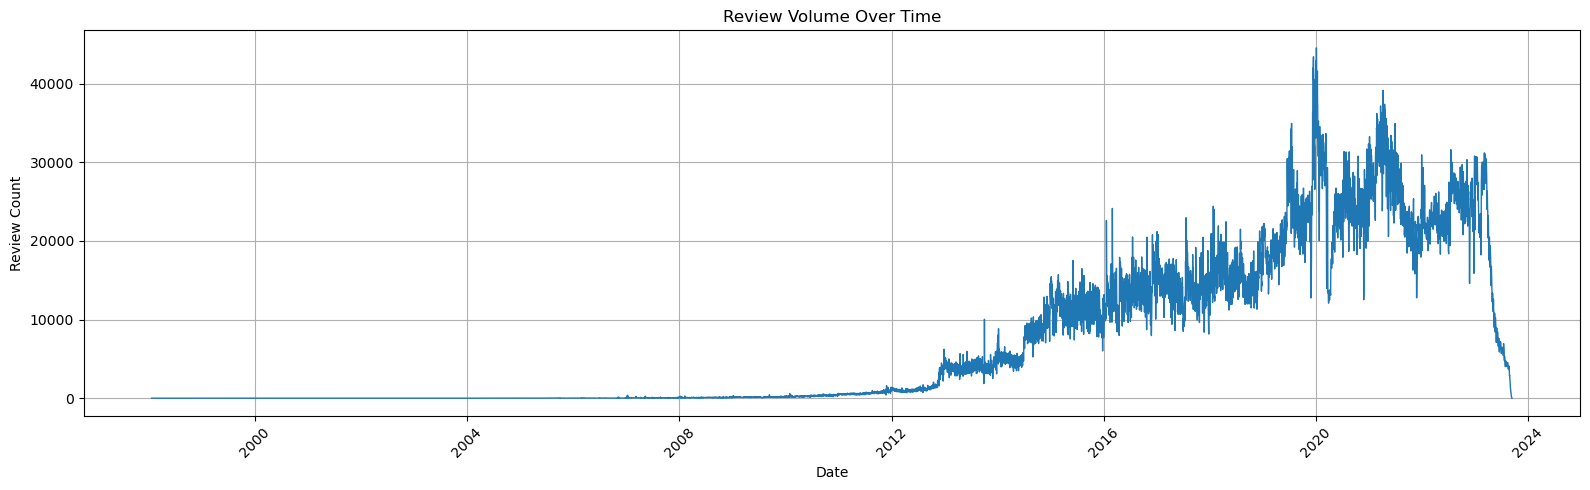

In [37]:
import matplotlib.pyplot as plt

df_timeline_pd['review_date'] = pd.to_datetime(df_timeline_pd['review_date'])

plt.figure(figsize=(16, 5))
plt.plot(df_timeline_pd['review_date'], df_timeline_pd['review_count'], linewidth=1)
plt.title("Review Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations from the above plot:**

- Low activity pre-2011: Likely early platform or limited review logging.
- Rapid growth 2012–2017: Steady user growth, e-commerce boom, more review prompts.
- Major spikes around 2019–2021:
  Possibly tied to COVID lockdowns and e-commerce surge.
  Some spikes might reflect fraudulent review surges or product launches.
- Sharp drop-off in 2023–2024:
  Could be due to incomplete recent data (e.g., delay in ingestion)
  Or potential moderation / policy changes

Worth filtering recent months to avoid skew

**So removing obvious outliers and replotting:**

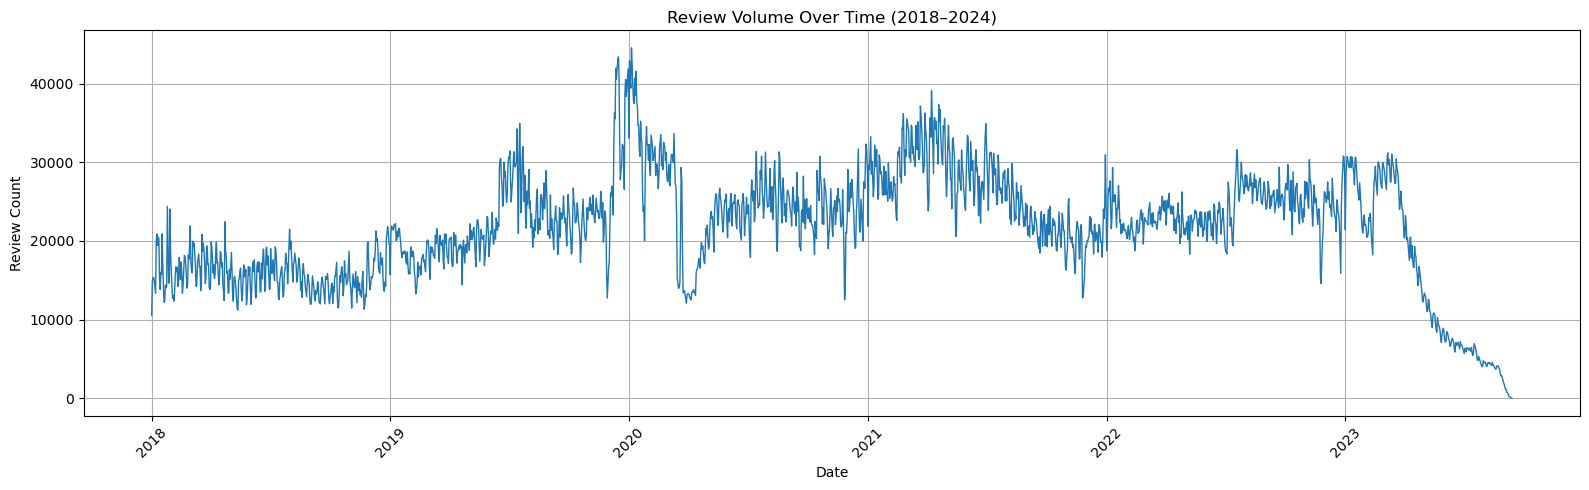

In [38]:
df_zoom = df_timeline_pd[df_timeline_pd['review_date'] >= '2018-01-01']

plt.figure(figsize=(16, 5))
plt.plot(df_zoom['review_date'], df_zoom['review_count'], linewidth=1)
plt.title("Review Volume Over Time (2018–2024)")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Q: What is the timeline of the data?**

Start: Late 1990s (very sparse)\
Substantial growth: Begins around 2012, with consistent growth\
Focus period (detailed view): 2018 to 2024

**Q: Do you see significant peaks and valleys?**

Yes, several significant peaks and valleys.

Peaks:

Late 2019–2020: Sharp spike — possibly tied to:\
COVID-19 lockdowns driving e-commerce and online reviews\
Surge in demand for home, tech, health, and hobby products\
Mid-2021: Another wave of high review activity (reopening + increased online shopping?)

Valleys:

Short dips throughout 2020–2021 could indicate:\
Shipping delays\
Product unavailability\
Changes in Amazon review policies

**Q: Do you see data collection gaps?**

Yes, there are data collection gaps

Post-2023: Steep drop, nearing zero\
Likely not a "real" event, but rather:\
Data not fully ingested for 2024\
Review logging delays

**Q: Do you see any outliers? Should we remove them?**

Extreme spikes (e.g., 40K+ reviews in a day)\
Sharp increase in daily review volume (~40K) observed in 2020, likely tied to COVID-driven surge in online shopping and possibly increased bot activity.

**Recommendation:** This might be real event caused, so we don't remove. 
However, later based on analysis we can maybe use rolling average for cleaner trend

**Q: Do you see any spikes?  Are these spikes caused by real events?**

Most likely yes. We see spikes around mid of every eyar(except 2021), which might be attributed to COVID-19 pandemic (2020): Shopping, home fitness, masks, hygiene products. Any product releases or seasonal buying (back to school, holidays). Prime day sale, Black friday sales & christmas sales(around year ends).

In [39]:
df_final.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_review_analysis/df_final_cleaned.parquet")

In [40]:
df_final.cache()
df_timeline.cache()

review_date,review_count
1998-01-19,4
1998-02-11,1
1998-02-19,1
1998-02-21,1
1998-02-25,2
1998-03-20,1
1998-04-22,1
1998-04-24,1
1998-06-08,1
1998-07-09,2


### Question-4: What are the top 10 products with the most reviews?

**How does their review count trend over time?**

In [42]:
from pyspark.sql.functions import count
df_top_products= df_final.select("asin","review_datetime").groupby("asin").agg(count("*").alias("review_count")) \
                      .orderBy("review_count", ascending= False)

***Top 10 products with most reviews:***

In [43]:
df_top_products.limit(10).toPandas()

,asin,review_count
0,B01415QHYW,43214
1,B01LSUQSB0,37146
2,B00T0C9XRK,33023
3,B001MA0QY2,27594
4,B079KZ49PJ,25994
5,B073R68TSH,25583
6,B07H2V5YLH,24735
7,B01LXZDPDR,22565
8,B07HRN9J19,22250
9,B00PGJWYJ0,20655


**Review count trend over time:**

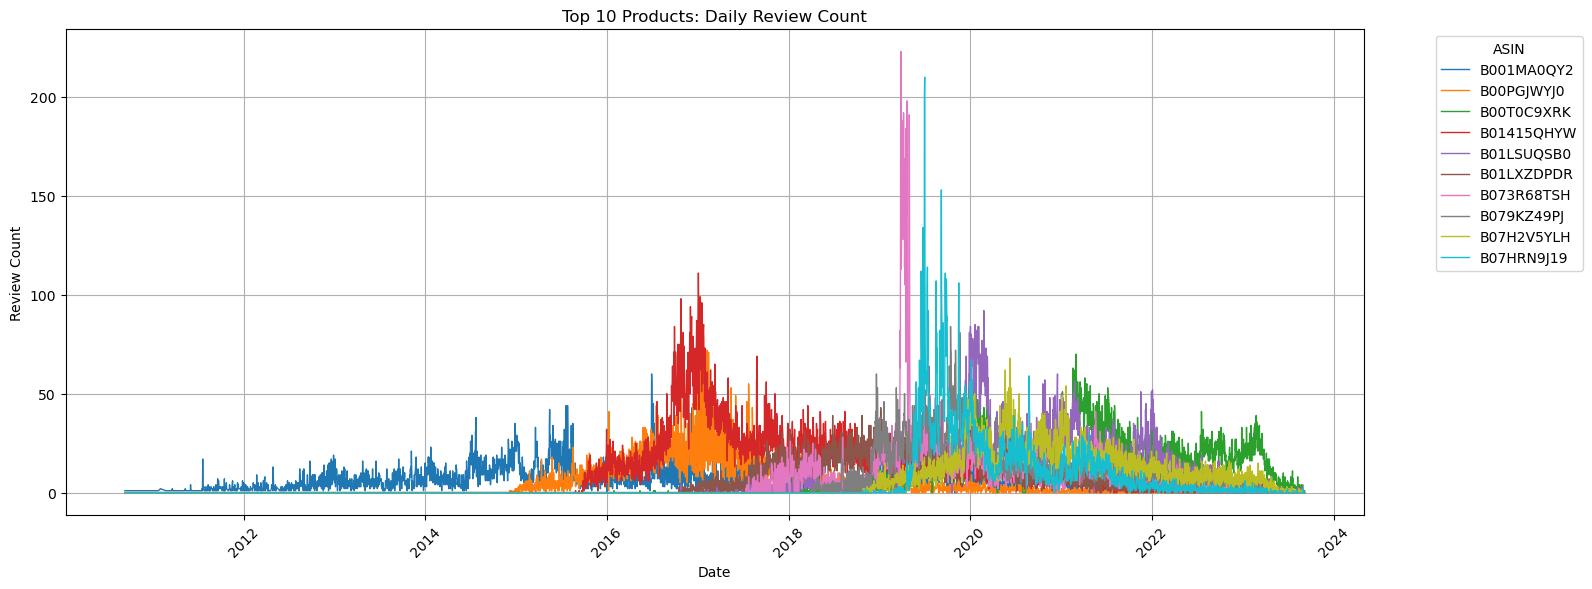

In [44]:
from pyspark.sql.functions import col, count, to_date
import matplotlib.pyplot as plt
import pandas as pd

df_top_products = df_final.groupBy("asin").agg(count("*").alias("review_count")) \
                          .orderBy("review_count", ascending=False).limit(10)

top_asins = df_top_products.select("asin").rdd.flatMap(lambda x: x).collect()

df_top_reviews = df_final.filter(col("asin").isin(top_asins)) \
                         .withColumn("review_date", to_date("review_datetime"))

df_trend = df_top_reviews.groupBy("review_date", "asin") \
                         .agg(count("*").alias("count")) \
                         .orderBy("review_date")

df_trend_pd = df_trend.toPandas()
df_pivot = df_trend_pd.pivot(index="review_date", columns="asin", values="count").fillna(0)

plt.figure(figsize=(16, 6))
df_pivot.plot(ax=plt.gca(), linewidth=1)
plt.title("Top 10 Products: Daily Review Count")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title="ASIN", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Identified the 10 most-reviewed products on Amazon and analyzed their review timelines. Most products exhibit a spike followed by a tapering off, consistent with typical product life cycles. A few ASINs( B073R68TSH, B07HRN9J19) show anomalously sharp increases (200+ daily reviews), possibly indicating promotional events or coordinated review activity. Many review peaks cluster around 2020–2021, likely reflecting shifts in consumer behavior during the COVID-19 pandemic.

B001MAOQY2 seems to have long-term stable reviews, suggesting it's a durable or evergreen product.

### Question-5: How does review volume vary across product categories (e.g., Books, Electronics, Beauty)?

**Do certain categories see spikes in review volume during specific months (e.g., holidays, sales)?**

In [45]:
from pyspark.sql.functions import to_date, count

df_final = df_final.withColumn("review_date", to_date("review_datetime"))

df_category_trend = df_final.groupBy("review_date", "main_category") \
                            .agg(count("*").alias("review_count")) \
                            .orderBy("review_date")

In [46]:
df_category_pd = df_category_trend.toPandas()
df_category_pivot = df_category_pd.pivot(index="review_date", columns="main_category", values="review_count").fillna(0)

**Review volume across product categories:**

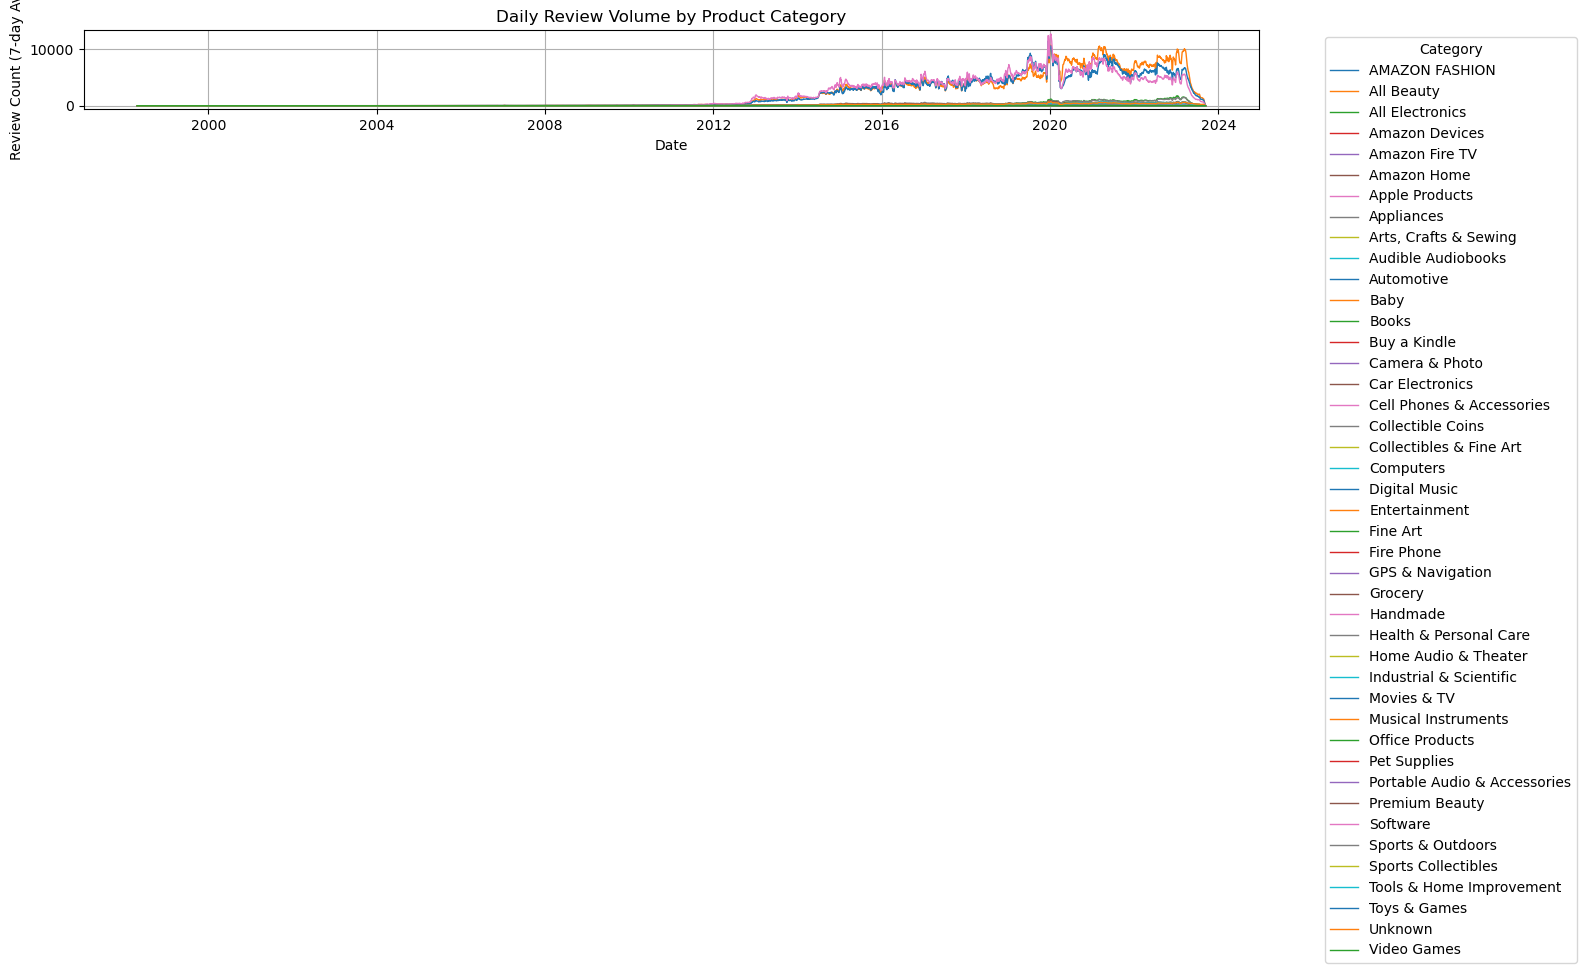

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
df_category_pivot.rolling(7).mean().plot(ax=plt.gca(), linewidth=1)
plt.title("Daily Review Volume by Product Category")
plt.xlabel("Date")
plt.ylabel("Review Count (7-day Avg)")
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Observations:**

- All Beauty and All Electronics categories show very noticeable spikes around November–December, which aligns with:Black Friday, Cyber Monday, Christmas shopping , maybe because these have more deals.

- Amazon Fashion and Cell Phones & Accessories also peak seasonally:
Likely linked to back-to-school, holiday promotions, or Prime Day
Smaller spikes seen around mid-year (June–July) in many categories could relate to:
Amazon Prime Day (usually mid-July)
Summer sales and travel-related purchases
Categories like Books, Software, and Digital Music are flatter or consistent:
Suggests non-seasonal consumption (steady demand throughout the year)

In [48]:
df_seasonal = df_final.filter((col("review_date") >= "2018-01-01") & (col("review_date") < "2023-01-01"))

In [49]:
from pyspark.sql.functions import month, year

df_seasonal = df_seasonal.withColumn("month", month("review_date")) \
                         .withColumn("year", year("review_date"))

In [50]:
df_monthly_cat = df_seasonal.groupBy("main_category", "month") \
                            .agg(count("*").alias("monthly_review_count")) \
                            .orderBy("main_category", "month")
df_monthly_pd = df_monthly_cat.toPandas()
df_pivot = df_monthly_pd.pivot(index="month", columns="main_category", values="monthly_review_count").fillna(0)

***Table: Monthly Review volume across product categories***

In [54]:
df_pivot

main_category,AMAZON FASHION,All Beauty,All Electronics,Amazon Devices,Amazon Fire TV,Amazon Home,Apple Products,Appliances,"Arts, Crafts & Sewing",Audible Audiobooks,Automotive,Baby,Books,Buy a Kindle,Camera & Photo,Car Electronics,Cell Phones & Accessories,Collectible Coins,Computers,Digital Music,Entertainment,Fine Art,Fire Phone,GPS & Navigation,Grocery,Handmade,Health & Personal Care,Home Audio & Theater,Industrial & Scientific,Movies & TV,Musical Instruments,Office Products,Pet Supplies,Portable Audio & Accessories,Premium Beauty,Software,Sports & Outdoors,Sports Collectibles,Tools & Home Improvement,Toys & Games,Unknown,Video Games
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,53485.0,1086000.0,117949.0,97.0,0.0,71690.0,54.0,2664.0,2779.0,0.0,917150.0,1623.0,941.0,13.0,16652.0,5324.0,1090375.0,1.0,18154.0,30.0,1.0,2.0,28.0,95.0,2623.0,109.0,111679.0,3349.0,45017.0,56.0,1249.0,3629.0,2050.0,1073.0,74526.0,11.0,17101.0,2.0,64274.0,4817.0,66524.0,1154.0
2,42828.0,958517.0,95871.0,62.0,0.0,59326.0,23.0,2142.0,2393.0,0.0,804229.0,1367.0,665.0,14.0,13333.0,4499.0,866134.0,3.0,15088.0,23.0,0.0,1.0,11.0,83.0,2387.0,71.0,98359.0,2650.0,40974.0,34.0,1043.0,3066.0,1600.0,810.0,65709.0,8.0,13808.0,2.0,56400.0,3195.0,55585.0,939.0
3,46546.0,1047129.0,104911.0,71.0,1.0,66103.0,35.0,2425.0,2701.0,0.0,913625.0,1428.0,667.0,17.0,14938.0,4847.0,928734.0,3.0,15262.0,28.0,0.0,1.0,19.0,82.0,2509.0,74.0,107707.0,2605.0,46072.0,48.0,1048.0,3239.0,1970.0,897.0,70067.0,4.0,15664.0,0.0,63594.0,3151.0,60620.0,782.0
4,43361.0,981553.0,95335.0,67.0,0.0,63259.0,35.0,2254.0,2518.0,1.0,851474.0,1414.0,630.0,65.0,14718.0,4213.0,798623.0,3.0,13848.0,23.0,0.0,3.0,20.0,70.0,2354.0,88.0,102366.0,2351.0,43422.0,30.0,938.0,2918.0,2029.0,777.0,65047.0,4.0,15660.0,0.0,60885.0,2977.0,55447.0,670.0
5,47084.0,1013958.0,98845.0,66.0,0.0,66637.0,22.0,2252.0,2580.0,0.0,897755.0,1525.0,549.0,19.0,14847.0,4574.0,826522.0,2.0,14516.0,17.0,0.0,3.0,14.0,75.0,2524.0,97.0,107640.0,2486.0,46316.0,31.0,1045.0,2947.0,2039.0,835.0,66730.0,5.0,17416.0,0.0,63607.0,2924.0,57973.0,860.0
6,50643.0,1005644.0,102994.0,70.0,1.0,68639.0,31.0,2385.0,2453.0,0.0,939937.0,1578.0,612.0,21.0,13915.0,4266.0,852225.0,1.0,14395.0,23.0,0.0,2.0,15.0,90.0,2510.0,93.0,108178.0,2507.0,48078.0,53.0,957.0,2988.0,1914.0,863.0,68570.0,4.0,19362.0,1.0,65837.0,3008.0,60253.0,848.0
7,57421.0,1094236.0,117799.0,92.0,0.0,75166.0,32.0,2832.0,2706.0,0.0,1053531.0,1816.0,533.0,20.0,15529.0,4804.0,940419.0,1.0,16026.0,24.0,0.0,4.0,24.0,99.0,2836.0,94.0,118144.0,2840.0,54738.0,38.0,1059.0,3297.0,2066.0,966.0,77514.0,3.0,21993.0,0.0,72423.0,3265.0,66582.0,800.0
8,54233.0,1036621.0,118491.0,70.0,0.0,72908.0,23.0,2990.0,2572.0,0.0,1005163.0,1696.0,491.0,11.0,15467.0,4625.0,882165.0,2.0,14313.0,33.0,1.0,3.0,24.0,129.0,2528.0,80.0,115928.0,2693.0,53542.0,35.0,978.0,3261.0,2027.0,826.0,72601.0,9.0,20548.0,0.0,70247.0,3022.0,63741.0,727.0
9,47784.0,893071.0,109625.0,56.0,0.0,64306.0,31.0,2369.0,2227.0,0.0,889387.0,1420.0,460.0,14.0,14247.0,4221.0,805093.0,0.0,12627.0,20.0,0.0,1.0,23.0,104.0,2175.0,77.0,99983.0,2357.0,48475.0,23.0,948.0,2973.0,1654.0,764.0,60769.0,1.0,17095.0,1.0,63597.0,2541.0,55820.0,682.0


**Do certain categories see spikes in review volume during specific months (e.g., holidays, sales)?**

**Observations:**

1. All Beauty\
Highest volume category overall(1M+ reviews/month)\
Strong spikes in July and December\
July → likely Amazon Prime Day\
December → holiday gifting\
Also high in March and May, suggesting potential seasonal promotions

2. All Electronics\
Consistent reviews across the year (~95K–140K monthly)\
Notable spike in December (140K) → holiday sales\
Mild bump in July (117K) could be Prime Day

3. Amazon Fashion\
Smaller overall volume compared to Beauty\
Sharp spike in December (58K) → seasonal clothing/gifting\
Also high in July (57K) → potentially summer sales or Prime Day

4. Toys & Games\
Biggest spike is in December (70K+), no surprise → Christmas gifting\
Stable around ~50–65K otherwise

5. Cell Phones & Accessories\
Peaks in January (1.09M) and December (1.02M)\
Strong presence year-round, but December bump aligns with holiday deals

6. Amazon Devices\
Very low overall volume
No meaningful spike — max is only ~97 reviews in January or July
This proves your earlier point: Amazon Devices do not have noticeable review spikes even during Prime Day or holidays

7. Arts, Crafts & Sewing\
Stable low-mid range volume (~2.5–2.8K per month)\
Slight increase in July and December, may reflect creative gifting or back-to-school projects

8. Books\
Review volume is surprisingly low (~500–900/month)\
December is lowest (430), which is counterintuitive\
Could suggest most book reviews occur independently of holidays

9. Health & Personal Care\
Very steady throughout the year (~65K–75K monthly)\
December is highest → possible holiday wellness gifting or New Year prep

10. Grocery\
Relatively low volume (~2–2.8K monthly)\
Very small December bump, may indicate gifting/seasonal purchases

**Summary Insights:**

***December:*** Nearly all major categories show a review spike → aligned with Christmas & holiday sales\
***July:*** Slight bump in categories like Beauty, Electronics, and Fashion → corresponds to Amazon Prime Day\
***Books:*** Opposite trend — lowest in December, possibly due to offline gift giving or delay in review writing\
***Health & Personal Care:*** Consistently steady — indicates non-seasonal demand

**Plot: Monthly Review Volume by Product Category**

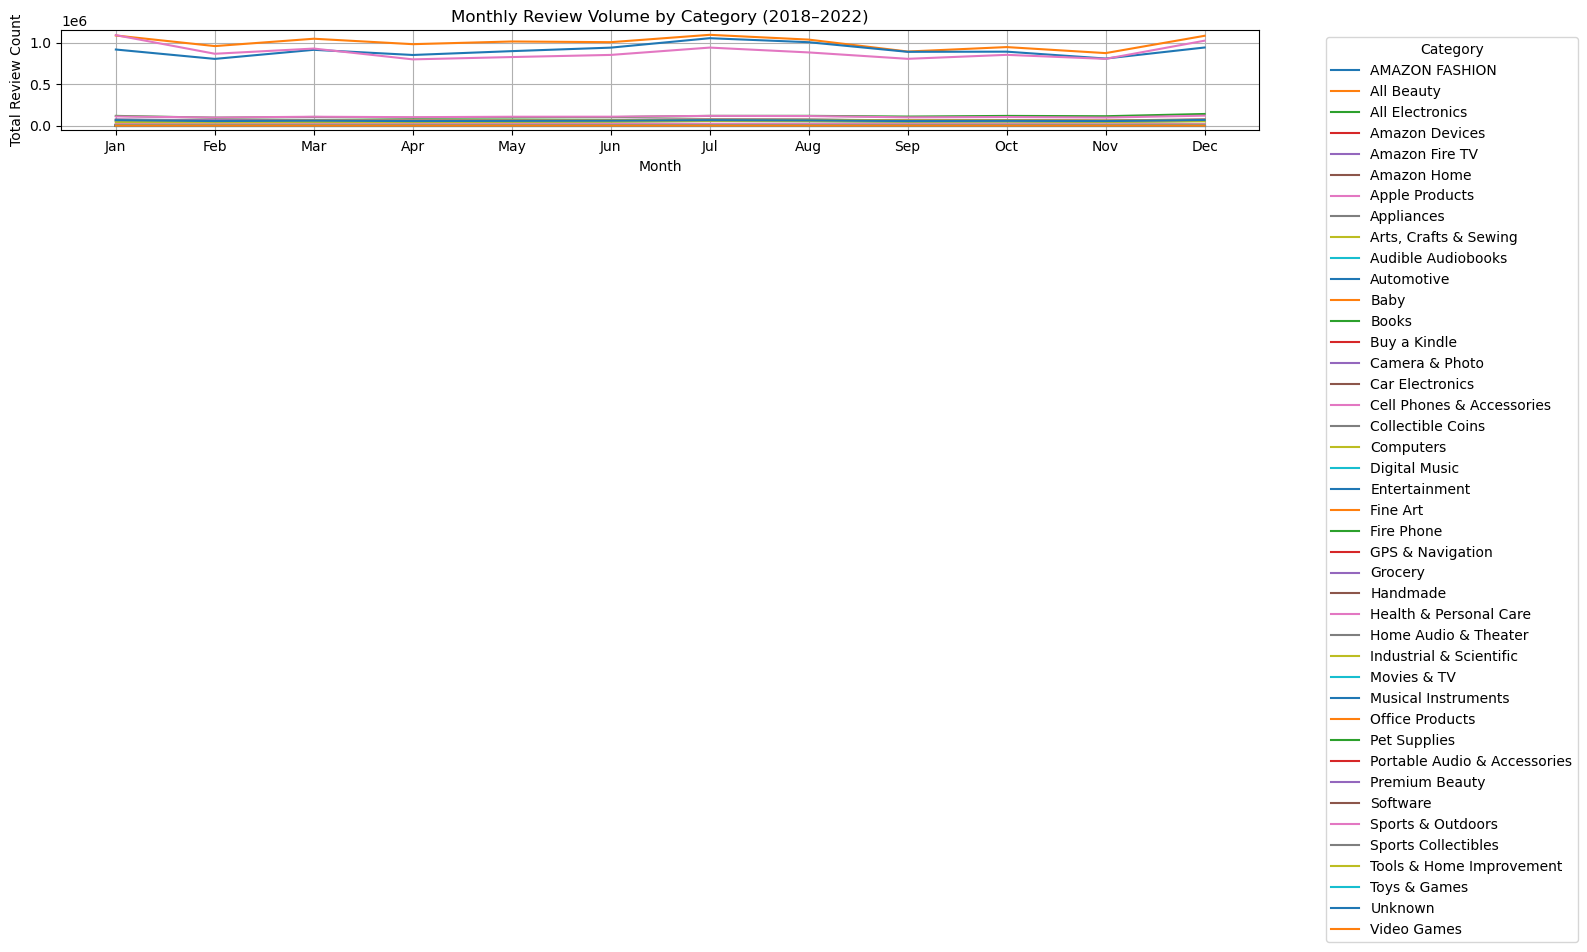

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
df_pivot.plot(ax=plt.gca())
plt.title("Monthly Review Volume by Category (2018–2022)")
plt.xlabel("Month")
plt.ylabel("Total Review Count")
plt.grid(True)
plt.xticks(ticks=range(1,13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Observations:**

- Categories like All Beauty, Amazon Fashion, Electronics, and Cell Phones & Accessories show clear increases in December.
Probably due to Holiday season / Christmas shopping, Gift purchases,which means more deliveries hence more reviews
- Mild rise in categories like Electronics and Amazon products during July possibly due to Amazon Prime Day (usually in mid-July)
- Flat/Stable Categories: Books, Software, or Handmade appear fairly flat → no strong monthly shifts which indicates non-seasonal or consistent year-round demand

We observe strong seasonality in review volume across many product categories. In particular, December consistently shows review spikes for fashion, beauty, and electronics — likely driven by holiday gifting. Additionally, slight upticks around July may correspond to Amazon Prime Day, especially in electronics-related categories. Some categories like Books and Software show relatively stable review trends year-round.

### Question-6: Are products with extremely high average ratings (4.9–5.0) also the most-reviewed?

In [59]:
from pyspark.sql.functions import avg, count

# Group by product
df_product_stats = df_final.groupBy("asin") \
    .agg(
        count("*").alias("total_reviews"),
        avg("rating").alias("avg_rating")
    )
df_highly_rated = df_product_stats.filter((col("avg_rating") >= 4.9) & (col("avg_rating") <= 5.0))

# Top 10 most-reviewed products
top_reviewed = df_product_stats.orderBy(col("total_reviews").desc()).limit(10)

# Join to check if they are also highly rated
top_and_highly_rated = top_reviewed.join(df_highly_rated, on="asin", how="inner")

top_and_highly_rated.show()

+----+-------------+----------+-------------+----------+
|asin|total_reviews|avg_rating|total_reviews|avg_rating|
+----+-------------+----------+-------------+----------+
+----+-------------+----------+-------------+----------+



In [62]:
top_reviewed.select("asin", "total_reviews", "avg_rating").show(truncate=False)

+----------+-------------+-----------------+
|asin      |total_reviews|avg_rating       |
+----------+-------------+-----------------+
|B01415QHYW|43214        |4.291618456981534|
|B01LSUQSB0|37146        |4.342055672212351|
|B00T0C9XRK|33023        |3.990370347939315|
|B001MA0QY2|27594        |4.304740160904545|
|B079KZ49PJ|25994        |4.015272755251212|
|B073R68TSH|25583        |4.368447797365438|
|B07H2V5YLH|24735        |4.090923792197291|
|B01LXZDPDR|22565        |4.248703744737425|
|B07HRN9J19|22250        |4.262786516853932|
|B00PGJWYJ0|20655        |4.256354393609295|
+----------+-------------+-----------------+



In [63]:
df_highly_rated.orderBy(col("total_reviews").desc()).show(10, truncate=False)

+----------+-------------+------------------+
|asin      |total_reviews|avg_rating        |
+----------+-------------+------------------+
|B0744GJQS3|2246         |4.903383793410508 |
|B00DDLYCUW|1353         |4.994826311899483 |
|B07446VHG8|1200         |4.905             |
|B00EI8SS4U|959          |4.997914494264859 |
|B0BNL134KP|531          |4.934086629001883 |
|B00BZSE5CK|525          |4.914285714285715 |
|B073G2J6H1|524          |4.927480916030534 |
|B00JD2GGM2|515          |4.922330097087379 |
|B07H97M3RN|497          |4.903420523138833 |
|B000S2UGWC|485          |4.9402061855670105|
+----------+-------------+------------------+
only showing top 10 rows



***Seeing both, it is obvious that the highly rated products aren't the most reviewed ones. Popular products tend to attract a wider range of opinions, pulling average ratings slightly lower. This suggests that high review count is often driven by popularity, not necessarily satisfaction alone.***

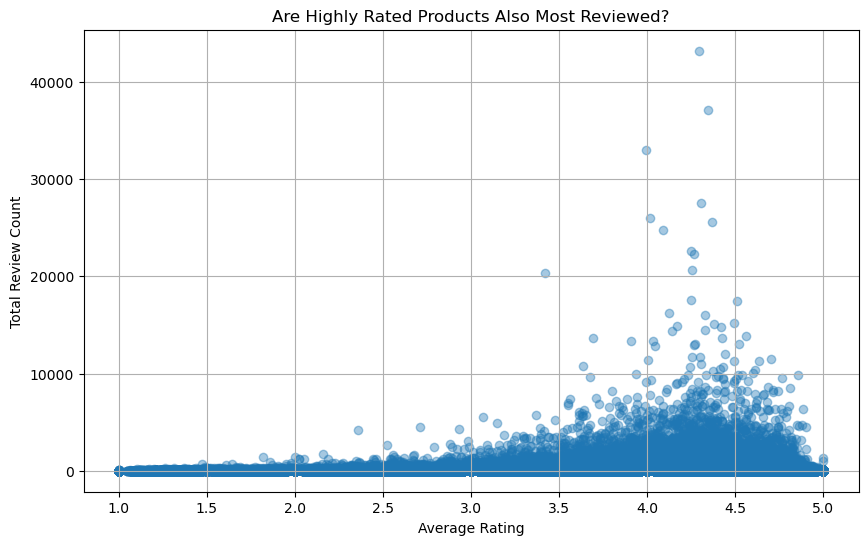

In [64]:
df_stats_pd = df_product_stats.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_stats_pd["avg_rating"], df_stats_pd["total_reviews"], alpha=0.4)
plt.xlabel("Average Rating")
plt.ylabel("Total Review Count")
plt.title("Are Highly Rated Products Also Most Reviewed?")
plt.grid(True)
plt.show()

### Question-7: Is there a relationship between product price and average rating or review volume?

In [66]:
from pyspark.sql.functions import col, when

df_final = df_final.withColumn(
    "price_clean",
    when(col("price").cast("double") == -1, None).otherwise(col("price").cast("double"))
)

df_price_stats = df_final.groupBy("asin").agg(
    avg("price_clean").alias("avg_price"),
    avg("rating").alias("avg_rating"),
    count("*").alias("review_volume")
).filter(col("avg_price").isNotNull())

df_price_stats.orderBy("avg_price", ascending=False).show(10)

+----------+---------+----------+-------------+
|      asin|avg_price|avg_rating|review_volume|
+----------+---------+----------+-------------+
|B0C3L2FJNZ|  15799.0|       5.0|            1|
|B07K5HT21M|  13650.0|       5.0|            2|
|B08TTJ8VXB| 12999.99|       1.0|            1|
|B07XVQH3DN| 12349.65|       3.0|            1|
|B00BEHUONG| 12006.01|       4.0|            1|
|B000X1E12E| 11192.34|       4.4|            5|
|B082MQZF5N|  10999.0|       5.0|            1|
|B082MPK4V3|  10999.0|       1.0|            1|
|B082MPPJLW|  10999.0|       5.0|            1|
|B0015DMKOA| 10074.98|       1.0|            1|
+----------+---------+----------+-------------+
only showing top 10 rows



In [67]:
df_price_stats.orderBy("review_volume", ascending=False).show(10)

+----------+------------------+-----------------+-------------+
|      asin|         avg_price|       avg_rating|review_volume|
+----------+------------------+-----------------+-------------+
|B01415QHYW| 6.980000000001535|4.291618456981534|        43214|
|B01LSUQSB0|38.800000000026635|4.342055672212351|        37146|
|B00T0C9XRK| 4.989999999999913|3.990370347939315|        33023|
|B001MA0QY2| 41.60999999999778|4.304740160904545|        27594|
|B079KZ49PJ|15.989999999994346|4.015272755251212|        25994|
|B073R68TSH| 19.98999999999366|4.368447797365438|        25583|
|B07H2V5YLH| 7.980000000002635|4.090923792197291|        24735|
|B01LXZDPDR| 6.990000000000326|4.248703744737425|        22565|
|B07HRN9J19|11.989999999996387|4.262786516853932|        22250|
|B00PGJWYJ0|10.989999999997384|4.256354393609295|        20655|
+----------+------------------+-----------------+-------------+
only showing top 10 rows



In [68]:
df_price_stats.orderBy("avg_rating", ascending=False).show(10)

+----------+---------+----------+-------------+
|      asin|avg_price|avg_rating|review_volume|
+----------+---------+----------+-------------+
|B087CZ45H9|    29.99|       5.0|            4|
|B01GRPYYLW|    12.99|       5.0|            1|
|B082BB7Q8H|     8.59|       5.0|            1|
|B09HK1729Q|    12.99|       5.0|            1|
|B087BCSDKY|    12.99|       5.0|            1|
|B00LPUP842|    949.0|       5.0|            1|
|B0B3TF8FBT|     9.99|       5.0|            1|
|B0BG1R65T8|    11.99|       5.0|            1|
|B0BWGXRY7P|    11.95|       5.0|            1|
|B08QQM59SK|    26.95|       5.0|            2|
+----------+---------+----------+-------------+
only showing top 10 rows



In [69]:
df_price_pd = df_price_stats.toPandas()

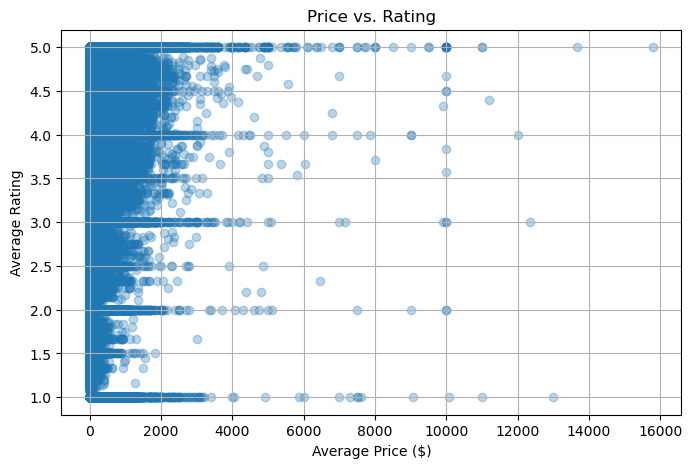

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df_price_pd["avg_price"], df_price_pd["avg_rating"], alpha=0.3)
plt.xlabel("Average Price ($)")
plt.ylabel("Average Rating")
plt.title("Price vs. Rating")
plt.grid(True)
plt.show()

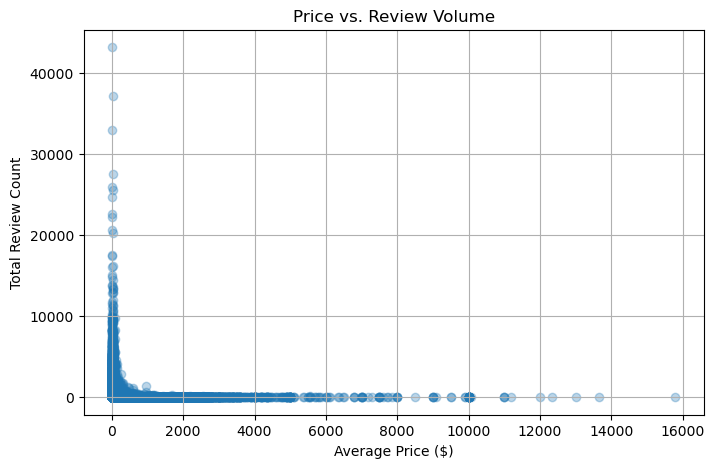

In [72]:
plt.figure(figsize=(8, 5))
plt.scatter(df_price_pd["avg_price"], df_price_pd["review_volume"], alpha=0.3)
plt.xlabel("Average Price ($)")
plt.ylabel("Total Review Count")
plt.title("Price vs. Review Volume")
plt.grid(True)
plt.show()

***So we can say the low priced products have more review_volume which seems fair, as more people might buy and review them. 
We can also say that most highly rated products are usually prices upto an average of $6000. So nominal the price, higher the review volume and ratings. However, some high priced products also have high ratings, but the review volume is very low.***

In [1]:
df_final = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_review_analysis/df_final_cleaned.parquet")

### Question-8: What are the most common words or phrases in 5-star vs. 1-star reviews?

In [2]:
from pyspark.sql.functions import col

df_5star = df_final.filter(col("rating") == 5.0).select("text")
df_1star = df_final.filter(col("rating") == 1.0).select("text")

In [3]:
df_5star.select("text").write.mode("overwrite").text("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews")
df_1star.select("text").write.mode("overwrite").text("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews")

***Loading 5-Star reviews:***

In [2]:
!mkdir full_5star
!gsutil -m cp "gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-*" full_5star/
!cat full_5star/* > all_5star_reviews.txt

Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-00000-830558fd-33e7-4530-89af-5869ef1e6bd9-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-00001-830558fd-33e7-4530-89af-5869ef1e6bd9-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-00002-830558fd-33e7-4530-89af-5869ef1e6bd9-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-00013-830558fd-33e7-4530-89af-5869ef1e6bd9-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-00006-830558fd-33e7-4530-89af-5869ef1e6bd9-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/part-00003-830558fd-33e7-4530-89af-5869ef1e6bd9-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/5star_reviews/par

**Top 5-Star Review words:**

In [3]:
import re
from collections import Counter

counter = Counter()

with open("all_5star_reviews.txt", "r") as f:
    for line in f:
        words = re.findall(r'\w+', line.lower())
        counter.update(words)

top_5star_words = counter.most_common(30)

NameError: name 'top_1star_words' is not defined

**With custom stop words:**

In [6]:
stop_words = {
    'the', 'and', 'i', 'to', 'a', 'it', 'is', 'in', 'that', 'of', 'was', 'for', 'this', 'with', 'my',
    'you', 'on', 'but', 'have', 'not', 'are', 'so', 'be', 'at', 'as', 'they', 'if', 'just', 'or', 'we',
    'also', 't', 's', 'br', 'u', 'one', 'would', 'get', 'like', 'really', 'even'
}

# Filter out stopwords
filtered_words = {word: count for word, count in counter.items() if word not in stop_words and len(word) > 2}

# Get the top 30 cleaned words
top_filtered_5star_words = Counter(filtered_words).most_common(30)

# Show result
print("Top 5-star words (cleaned):")
for word, freq in top_filtered_5star_words:
    print(f"{word}: {freq}")

Top 5-star words (cleaned):
great: 11476554
very: 7808858
love: 7092712
product: 6719990
good: 6129728
phone: 5338980
easy: 5271982
use: 5110640
case: 4862995
well: 4594556
works: 4287403
hair: 4266230
these: 4111248
all: 4000960
can: 3656887
will: 3481126
had: 3439110
perfect: 3339098
out: 3230378
has: 3066855
your: 3046400
when: 3026235
nice: 2963484
them: 2950532
price: 2916151
fit: 2901886
from: 2875587
quality: 2678254
than: 2649459
used: 2624863


***Loading 1-Star reviews:***

In [7]:
!mkdir full_1star
!gsutil -m cp "gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-*" full_1star/
!cat full_1star/* > all_1star_reviews.txt

Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-00015-92cd408d-089b-4adc-a973-1606659277b1-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-00000-92cd408d-089b-4adc-a973-1606659277b1-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-00010-92cd408d-089b-4adc-a973-1606659277b1-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-00001-92cd408d-089b-4adc-a973-1606659277b1-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-00002-92cd408d-089b-4adc-a973-1606659277b1-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/part-00009-92cd408d-089b-4adc-a973-1606659277b1-c000.txt...
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/1star_reviews/par

**Top 1-Star Review words:**

In [9]:
stop_words = {
    'the', 'and', 'i', 'to', 'a', 'it', 'is', 'in', 'that', 'of', 'was', 'for',
    'this', 'with', 'my', 'you', 'on', 'but', 'have', 'not', 'are', 'so', 'be',
    'at', 'as', 'they', 'if', 'just', 'or', 'we', 'also', 'one', 'would', 'get',
    'like', 'really', 'even'
}

counter = Counter()

with open("all_1star_reviews.txt", "r") as f:
    for line in f:
        words = re.findall(r"\b[\w']+\b", line.lower())
        clean_words = [w for w in words if w not in stop_words and len(w) > 2]
        counter.update(clean_words)

top_1star_words = counter.most_common(30)

print("Top 1-star words (cleaned, contractions preserved):")
for word, count in top_1star_words:
    print(f"{word}: {count}")

Top 1-star words (cleaned, contractions preserved):
product: 1595201
phone: 1363495
all: 1231633
very: 1223599
had: 1159302
out: 1087140
off: 1035716
after: 1000380
case: 953307
work: 939220
when: 891656
use: 877060
will: 848646
from: 837969
money: 831207
fit: 817617
your: 816266
did: 796696
screen: 793459
these: 779572
buy: 730259
them: 723818
hair: 715935
only: 711736
does: 711177
time: 705102
back: 618659
used: 600202
what: 596573
good: 584463


In [10]:
!gsutil cp all_5star_reviews.txt gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/

!gsutil cp all_1star_reviews.txt gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/

Copying file://all_5star_reviews.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  5.8 GiB/  5.8 GiB]   50.5 MiB/s                                   
Operation completed over 1 objects/5.8 GiB.                                      
Copying file://all_1star_reviews.txt [Content-Type=text/plain]...
==> NOTE: You are u

In [1]:
!gsutil cp gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/all_5star_reviews.txt .
!gsutil cp gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/all_1star_reviews.txt .

Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/all_5star_reviews.txt...
- [1 files][  5.8 GiB/  5.8 GiB]   52.9 MiB/s                                   
Operation completed over 1 objects/5.8 GiB.                                      
Copying gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_reviews/all_1star_reviews.txt...
- [1 files][  1.4 GiB/  1.4 GiB]   44.7 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


### Question-9: Identify the most active reviewers

In [1]:
df_final = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_review_analysis/df_final_cleaned.parquet")

**Q: By Count**

In [2]:
from pyspark.sql.functions import count

most_active_reviewers = df_final.groupBy("user_id") \
    .agg(count("*").alias("review_count")) \
    .orderBy("review_count", ascending=False)

most_active_reviewers.show(10, truncate=False)

+------------------------------+------------+
|user_id                       |review_count|
+------------------------------+------------+
|AG73BVBKUOH22USSFJA5ZWL7AKXA  |3448        |
|AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1|2394        |
|AEMP3A7IKW37CMWFXNKXWW6HGJHA_1|2328        |
|AFXF3EGQTQDXMRLDWFU7UBFQZB7Q  |2031        |
|AH2DN3Q2OKAW7JAFRIYPHOUOM2ZQ  |1917        |
|AEAXAJACFMXIAAH4WOHRMXPSZWFA  |1849        |
|AEZP6Z2C5AVQDZAJECQYZWQRNG3Q  |1784        |
|AFF6DS6NOWRIF2AROFASUVVOPYLA  |1574        |
|AHV6QCNBJNSGLATP56JAWJ3C4G2A  |1480        |
|AGYVC7KVHP2AWM7BDCEYNHFA6F3Q  |1358        |
+------------------------------+------------+
only showing top 10 rows



**Q: Do top reviewers write across diverse categories or just a few?**

In [3]:
from pyspark.sql.functions import countDistinct

# Top 20 reviewers
top_reviewers = most_active_reviewers.limit(20).select("user_id")

top_reviewers_categories = df_final.join(top_reviewers, on="user_id", how="inner") \
    .groupBy("user_id") \
    .agg(countDistinct("main_category").alias("distinct_categories")) \
    .orderBy("distinct_categories", ascending=False)

top_reviewers_categories.show(10, truncate=False)

25/05/25 18:43:13 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.



+------------------------------+-------------------+
|user_id                       |distinct_categories|
+------------------------------+-------------------+
|AG73BVBKUOH22USSFJA5ZWL7AKXA  |25                 |
|AEAXAJACFMXIAAH4WOHRMXPSZWFA  |20                 |
|AHPGHDFIU3BUB3RQBP56RQQA7W4Q  |18                 |
|AHV6QCNBJNSGLATP56JAWJ3C4G2A  |18                 |
|AHGIDR4IJFS23Q4GTZ33FI5LYDSQ_1|17                 |
|AFXF3EGQTQDXMRLDWFU7UBFQZB7Q  |17                 |
|AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1|16                 |
|AGYVC7KVHP2AWM7BDCEYNHFA6F3Q  |16                 |
|AES3YWD3ONJOUDRWFIV2ZO44QDAQ  |16                 |
|AHY2TURQPNIDXZGH2CMQLZ343YMQ  |16                 |
+------------------------------+-------------------+
only showing top 10 rows



### Question-10: How unique are the “title” and “review” values? Pick only ONE category of your choice, you may apply sampling if needed.

***
- Are they mostly unique? Or are people usually just copy-pasting the same text?
- You can use LSH to measure uniqueness / similarity
- Visualize “review titles” and “review texts” duplication
- Visualize “review titles” and “review texts” duplication for each of the top 5 products
***

***Selecting the category "Beauty" as it is ever popular as per above plots***

In [4]:
from pyspark.sql.functions import col

# Filtering only one category: 'All Beauty' which is ever popular and sampling 10K reviews
df_beauty = df_final.filter(col("main_category") == "All Beauty").sample(fraction=0.1, seed=42).limit(10000)

In [5]:
df_beauty.limit(20).toPandas()

,asin,parent_asin,review_title,text,rating,helpful_vote,verified_purchase,user_id,review_datetime,price,main_category,categories,store
0,9790777396,9790777396,yummy!,"My husband is a real connoisseur of colognes, ...",5.0,0,True,AEI32GETUMHQTAARIKEWSDVVYZJA,2015-04-30 03:25:09,-1,All Beauty,"[Beauty & Personal Care, Fragrance, Men's, Eau...",Michael Kors
1,B00005308B,B00005308B,Pieces broke off the first time I tried to use...,Pieces broke off when I tried to use it.,1.0,0,True,AHTB4QKZ5FXM7VAR7PF4EUQDYEXQ,2022-06-04 17:46:07,7.5,All Beauty,"[Beauty & Personal Care, Men's Grooming, Body ...",Old Spice
2,B00005308B,B00005308B,Old Spice High Endurance Anti-Perspirant/Deodo...,This is &#34;Not&#34; the Invisible Solid as d...,1.0,4,True,AGEFL2PAZ2Z3GIQW3LVBWRYJ4AGA,2013-03-29 11:15:31,7.5,All Beauty,"[Beauty & Personal Care, Men's Grooming, Body ...",Old Spice
3,B0002B02AU,B0002B02AU,Four Stars,these work well for the price.,4.0,0,True,AHEKJB7G7RYO4NPEAHNUBAUYOLFQ,2015-07-25 04:38:00,-1,All Beauty,"[Beauty & Personal Care, Foot, Hand & Nail Car...",Sally Hansen
4,B0002B02AU,B0002B02AU,WORKS,Works great for those really thick nails.,4.0,0,True,AGWFFJO3PSL2HGZKA7JIPOZWRX5A,2015-04-11 15:22:27,-1,All Beauty,"[Beauty & Personal Care, Foot, Hand & Nail Car...",Sally Hansen
5,B0002JBSZA,B0002JBSZA,I just would like a larger size,"Just what I wanted, I just would like a larger...",5.0,0,True,AEKALXMSVFCIEOUDTYPZXEENN7OA,2016-12-02 18:15:17,18.0,All Beauty,"[Beauty & Personal Care, Fragrance, Men's, Eau...",S.T. Dupont
6,B0002TSAII,B0002TSAII,great mat!,"Got this for Christmas, and it's a thick mat! ...",4.0,0,False,AFCJJ5BA6AGQPKBZJY5FRBAYX2SQ,2014-12-25 21:51:26,-1,All Beauty,"[Beauty & Personal Care, Hair Care, Styling To...",N MARKET
7,B0002Z8OUQ,B0002Z8OUQ,Seem to be used and re-sharpened,There tweeter were not the same size as other ...,1.0,9,True,AFRORF6IURHUXEY2NRP2DYLZFACA,2013-05-27 15:47:25,-1,All Beauty,"[Beauty & Personal Care, Shave & Hair Removal,...",Mehaz
8,B0002Z8OUQ,B0002Z8OUQ,Five Stars,"Excellent Tweezers! Very high quality! Yes, ...",5.0,0,True,AHCYSKUFCMLYX725JS7YVGTPNGWQ,2017-02-05 16:36:33,-1,All Beauty,"[Beauty & Personal Care, Shave & Hair Removal,...",Mehaz
9,B0002Z8OUQ,B0002Z8OUQ,Four Stars,Excellent twizer!!!,4.0,0,True,AGVNIQWECUSWXFZBYPCIWACPDFXQ,2017-05-27 17:21:11,-1,All Beauty,"[Beauty & Personal Care, Shave & Hair Removal,...",Mehaz


***Understanding duplication rate in title and text before proceeding in depth***

In [6]:
unique_title_count=df_beauty.select("review_title").distinct().count()
unique_text_count=df_beauty.select("text").distinct().count()

In [7]:
total_count = df_beauty.count()
print("Title duplication rate:", round(100 * (1 - unique_title_count / total_count), 2), "%")
print("Text duplication rate :", round(100 * (1 - unique_text_count / total_count), 2), "%")

Title duplication rate: 27.46 %
Text duplication rate : 3.36 %


In [8]:
df_beauty.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_review_analysis/df_beauty.parquet")

In [2]:
df_beauty = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/amulyajayanti/amazon_review_analysis/df_beauty.parquet")

**Review Text (using MinHashLSH):**

In [6]:
from pyspark.sql.functions import col, split, monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.ml.feature import StopWordsRemover, CountVectorizer
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.functions import size

df_text = df_beauty.withColumn("id", monotonically_increasing_id())

# Remove punctuation and split into words
df_text = df_text.withColumn("clean_text", F.regexp_replace(F.col("text"), "[^a-zA-Z0-9\\s]", ""))
df_text = df_text.withColumn("words", split(F.col("clean_text"), " "))

# Remove short tokens
df_text = df_text.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))

# Remove stopwords
remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
df_text = remover.transform(df_text).select("id", "text", "filtered_words")

# Vectorize
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
df_vectorize_model = vectorizer.fit(df_text)
df_vectorize = df_vectorize_model.transform(df_text)

# Filter out rows with empty filtered_words to prevent empty sparse vectors
df_vectorize = df_vectorize.filter(size("filtered_words") > 0)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = model.transform(df_vectorize).cache()
df_hashed.count()  # Force evaluation and avoid lazy crashes

# LSH join
df_dups = model.approxSimilarityJoin(df_hashed, df_hashed, 0.3) \
    .filter("datasetA.id < datasetB.id") \
    .select(
        col("datasetA.id").alias("id_A"),
        col("datasetB.id").alias("id_B")
    )

# Distinct duplicated IDs
dup_ids = df_dups.select("id_A").union(df_dups.select("id_B")).distinct().count()

total_ids = df_hashed.select("id").distinct().count()
unique_count = total_ids - dup_ids

print("Total reviews:", total_ids)
print(f"Near-duplicate texts (Jaccard ≤ 0.3):", dup_ids)
print(f"Unique texts:", unique_count)

Total reviews: 9953
Near-duplicate texts (Jaccard ≤ 0.3): 710
Unique texts: 9243


**Review Title: (using MinHashLSH)**

In [7]:
from pyspark.sql.functions import col, split, monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.ml.feature import StopWordsRemover, CountVectorizer
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.functions import size

df_title = df_beauty.withColumn("id", monotonically_increasing_id())

# Remove punctuation and split into words
df_title = df_title.withColumn("clean_title", F.regexp_replace(F.col("review_title"), "[^a-zA-Z0-9\\s]", ""))
df_title = df_title.withColumn("words", split(F.col("clean_title"), " "))

# Remove short tokens
df_title = df_title.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))

# Remove stopwords
remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
df_title = remover.transform(df_title).select("id", "text", "filtered_words")

# Vectorize
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
df_vectorize_model = vectorizer.fit(df_title)
df_vectorize = df_vectorize_model.transform(df_title)

# Filter out rows with empty filtered_words to prevent empty sparse vectors
df_vectorize = df_vectorize.filter(size("filtered_words") > 0)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed_title = model.transform(df_vectorize).cache()
df_hashed_title.count()  # Force evaluation and avoid lazy crashes

# LSH join
df_dups_title = model.approxSimilarityJoin(df_hashed_title, df_hashed_title, 0.3) \
    .filter("datasetA.id < datasetB.id") \
    .select(
        col("datasetA.id").alias("id_A"),
        col("datasetB.id").alias("id_B")
    )

# Distinct duplicated IDs
dup_ids_title = df_dups_title.select("id_A").union(df_dups_title.select("id_B")).distinct().count()

total_ids_title = df_hashed_title.select("id").distinct().count()
unique_count_title = total_ids_title - dup_ids_title

print("Total reviews:", total_ids_title)
print(f"Near-duplicate texts (Jaccard ≤ 0.3):", dup_ids_title)
print(f"Unique texts:", unique_count_title)

Total reviews: 9875
Near-duplicate texts (Jaccard ≤ 0.3): 4161
Unique texts: 5714


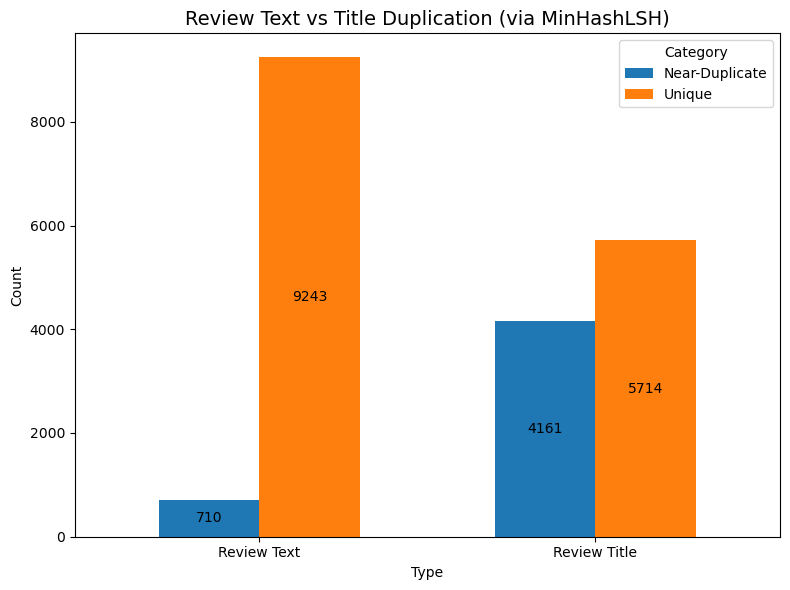

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    "Type": ["Review Text", "Review Text", "Review Title", "Review Title"],
    "Category": ["Unique", "Near-Duplicate", "Unique", "Near-Duplicate"],
    "Count": [9243, 710, 5714, 4161]
}

df_plot = pd.DataFrame(data)

# Pivot the data to get grouped bars
pivot_df = df_plot.pivot(index="Type", columns="Category", values="Count")

# Plot
ax = pivot_df.plot(kind="bar", figsize=(8, 6), width=0.6)
ax.set_title("Review Text vs Title Duplication (via MinHashLSH)", fontsize=14)
ax.set_ylabel("Count")

# Annotate bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=10)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Visualize “review titles” and “review texts” duplication for each of the top 5 products**

In [9]:
top5_asins = df_beauty.groupBy("asin").count().orderBy(F.desc("count")).limit(5).select("asin")
asin_list = [row["asin"] for row in top5_asins.collect()]

In [10]:
def get_duplication_counts(df, col_name):
    df = df.withColumn("id", monotonically_increasing_id())
    df_clean = df.withColumn("clean_text", F.regexp_replace(F.col(col_name), "[^a-zA-Z0-9\\s]", ""))
    df_clean = df_clean.withColumn("words", split(F.col("clean_text"), " "))
    df_clean = df_clean.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))
    
    remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
    df_clean = remover.transform(df_clean).select("id", col_name, "filtered_words")
    
    df_clean = df_clean.filter(size("filtered_words") > 0)
    
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
    model = vectorizer.fit(df_clean)
    df_vec = model.transform(df_clean)
    
    lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    lsh_model = lsh.fit(df_vec)
    df_hashed = lsh_model.transform(df_vec).cache()
    df_hashed.count()
    
    df_dups = lsh_model.approxSimilarityJoin(df_hashed, df_hashed, 0.3) \
        .filter("datasetA.id < datasetB.id") \
        .select(col("datasetA.id").alias("id_A"), col("datasetB.id").alias("id_B"))
    
    dup_ids = df_dups.select("id_A").union(df_dups.select("id_B")).distinct().count()
    total_ids = df_hashed.select("id").distinct().count()
    unique_ids = total_ids - dup_ids
    
    return unique_ids, dup_ids

In [11]:
results = []

for asin in asin_list:
    df_asin = df_beauty.filter(col("asin") == asin)
    
    unique_text, dup_text = get_duplication_counts(df_asin, "text")
    unique_title, dup_title = get_duplication_counts(df_asin, "review_title")
    
    results.append({
        "asin": asin,
        "type": "Text",
        "unique": unique_text,
        "duplicate": dup_text
    })
    results.append({
        "asin": asin,
        "type": "Title",
        "unique": unique_title,
        "duplicate": dup_title
    })

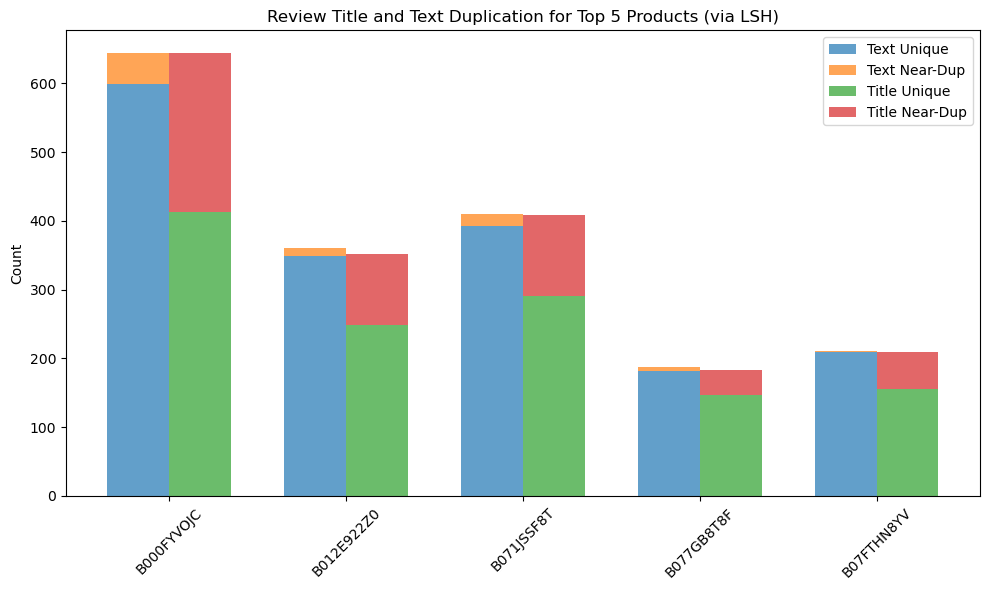

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

# Melt for seaborn-style grouped bar plotting
df_melted = df_results.melt(id_vars=["asin", "type"], value_vars=["unique", "duplicate"], 
                            var_name="category", value_name="count")

# Pivot for grouped bar chart
df_plot = df_melted.pivot_table(index=["asin", "type"], columns="category", values="count").reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
asin_list = df_plot["asin"].unique()
x = range(len(asin_list))

for i, value_type in enumerate(["Text", "Title"]):
    subset = df_plot[df_plot["type"] == value_type]
    ax.bar([p + i * bar_width for p in x], subset["unique"], width=bar_width, label=f"{value_type} Unique", alpha=0.7)
    ax.bar([p + i * bar_width for p in x], subset["duplicate"], width=bar_width, bottom=subset["unique"],
           label=f"{value_type} Near-Dup", alpha=0.7)

ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(asin_list, rotation=45)
ax.set_ylabel("Count")
ax.set_title("Review Title and Text Duplication for Top 5 Products (via LSH)")
ax.legend()
plt.tight_layout()
plt.show()

### Question-11: Compare the effectiveness of similarity-based detection (MinHashLSH) on recent reviews (e.g., 2022–2023) versus older reviews (pre-2022)

**- Are similarity detection techniques less effective on recent data due to more advanced or diversified AI-generated reviews?**

In [13]:
from pyspark.sql.functions import year

df_beauty = df_beauty.withColumn("year", year("review_datetime"))
df_recent = df_beauty.filter(col("year") >= 2022)
df_old = df_beauty.filter(col("year") < 2022)

In [14]:
def get_duplication_counts(df, col_name):
    df = df.withColumn("id", monotonically_increasing_id())
    df_clean = df.withColumn("clean_text", F.regexp_replace(F.col(col_name), "[^a-zA-Z0-9\\s]", ""))
    df_clean = df_clean.withColumn("words", split(F.col("clean_text"), " "))
    df_clean = df_clean.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))
    
    remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
    df_clean = remover.transform(df_clean).select("id", col_name, "filtered_words")
    
    df_clean = df_clean.filter(size("filtered_words") > 0)
    
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
    model = vectorizer.fit(df_clean)
    df_vec = model.transform(df_clean)
    
    lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    lsh_model = lsh.fit(df_vec)
    df_hashed = lsh_model.transform(df_vec).cache()
    df_hashed.count()
    
    df_dups = lsh_model.approxSimilarityJoin(df_hashed, df_hashed, 0.3) \
        .filter("datasetA.id < datasetB.id") \
        .select(col("datasetA.id").alias("id_A"), col("datasetB.id").alias("id_B"))
    
    dup_ids = df_dups.select("id_A").union(df_dups.select("id_B")).distinct().count()
    total_ids = df_hashed.select("id").distinct().count()
    unique_ids = total_ids - dup_ids
    percent_dup = round(100 * dup_ids / total_ids, 2)
    
    return total_ids, unique_ids, dup_ids, percent_dup

In [15]:
results = []

for label, subset in [("Recent (2022–2023)", df_recent), ("Older (pre-2022)", df_old)]:
    total, unique, dup, pct_dup = get_duplication_counts(subset, "text")
    results.append({
        "Period": label,
        "Total": total,
        "Unique": unique,
        "Duplicate": dup,
        "Duplication Rate (%)": pct_dup
    })

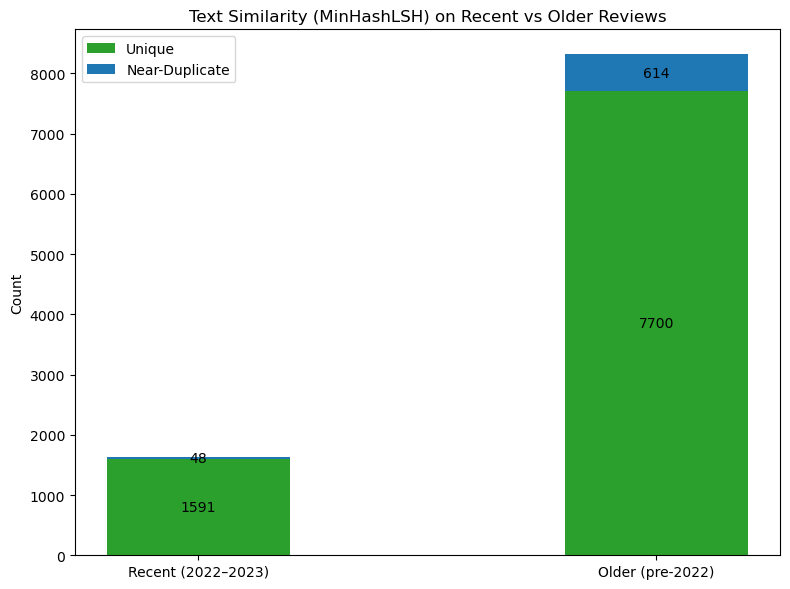

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(results)

# Bar plot for unique vs duplicate
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.4
x = range(len(df_plot))

# Bars
ax.bar(x, df_plot["Unique"], width=bar_width, label="Unique", color="C2")
ax.bar(x, df_plot["Duplicate"], width=bar_width, bottom=df_plot["Unique"], label="Near-Duplicate", color="C0")

# Labels
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Period"], rotation=0)
ax.set_ylabel("Count")
ax.set_title("Text Similarity (MinHashLSH) on Recent vs Older Reviews")
ax.legend()

# Annotate bars
for i, (u, d) in enumerate(zip(df_plot["Unique"], df_plot["Duplicate"])):
    ax.text(i, u / 2, str(u), ha="center", va="center", fontsize=10)
    ax.text(i, u + d / 2, str(d), ha="center", va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
print(df_plot[["Period", "Total", "Unique", "Duplicate", "Duplication Rate (%)"]])

               Period  Total  Unique  Duplicate  Duplication Rate (%)
0  Recent (2022–2023)   1639    1591         48                  2.93
1    Older (pre-2022)   8314    7700        614                  7.39


**Q: Are similarity detection techniques less effective on recent data due to more advanced or diversified AI-generated reviews?**

- Duplication rate in recent reviews is significantly lower than in older ones.
- This suggests that similarity-based detection (like MinHashLSH) is less effective on recent content.
- Possible reason for Recent reviews being more diversified:
  - Use of AI-generated paraphrasing tools
  - More deliberate efforts to avoid copy-paste
  - Richer, less templated language
  
***The MinHashLSH-based similarity detection shows a markedly higher duplication rate in older reviews (7.39%) compared to recent ones (2.93%). This suggests that recent reviews may be more linguistically diverse, possibly due to increased user effort or the growing use of AI-assisted writing tools. As such, traditional similarity detection techniques may be less effective for identifying patterns or fake content in recent reviews***